In [21]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer
from nltk import sent_tokenize, word_tokenize, pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
import logging
 


In [22]:
df = pd.read_csv("Amazon_Unlocked_Mobile.csv")
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [23]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413840 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  413840 non-null  object 
 1   Brand Name    348669 non-null  object 
 2   Price         407907 non-null  float64
 3   Rating        413840 non-null  int64  
 4   Reviews       413778 non-null  object 
 5   Review Votes  401544 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 18.9+ MB


In [12]:
print("Summary static of numerical feture :\n" , df.describe())
print("\n Total number of review" , len(df["Reviews"]))
print("\nTotal number of brands:", df["Brand Name"].nunique())
print("\nTotal number of unique products:",df["Product Name"].nunique())
print("\nPercentage of reviews with neutral sentiment : {:.2f}%".format(df[df.Rating == 3].Reviews.count()/len(df['Rating'])*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%".format(df[df.Rating >3].Reviews.count()/len(df['Rating'])*100) )
print("\nPercentage of reviews with negative sentiment : {:.2f}%".format(df[df.Rating < 3].Reviews.count()/len(df['Rating'])*100))

Summary static of numerical feture :
                Price         Rating   Review Votes
count  407907.000000  413840.000000  401544.000000
mean      226.867155       3.819578       1.507237
std       273.006259       1.548216       9.163853
min         1.730000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       144.710000       5.000000       0.000000
75%       269.990000       5.000000       1.000000
max      2598.000000       5.000000     645.000000

 Total number of review 413840

Total number of brands: 384

Total number of unique products: 4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


Text(0, 0.5, 'Count')

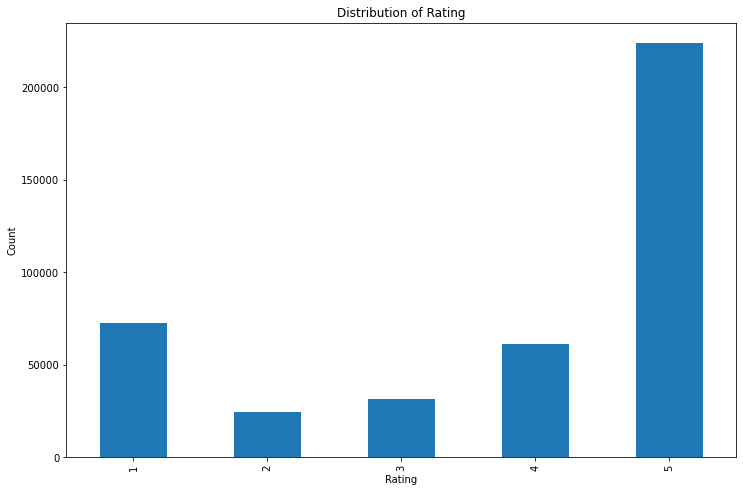

In [15]:
plt.figure(figsize=(12,8))
df['Rating'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

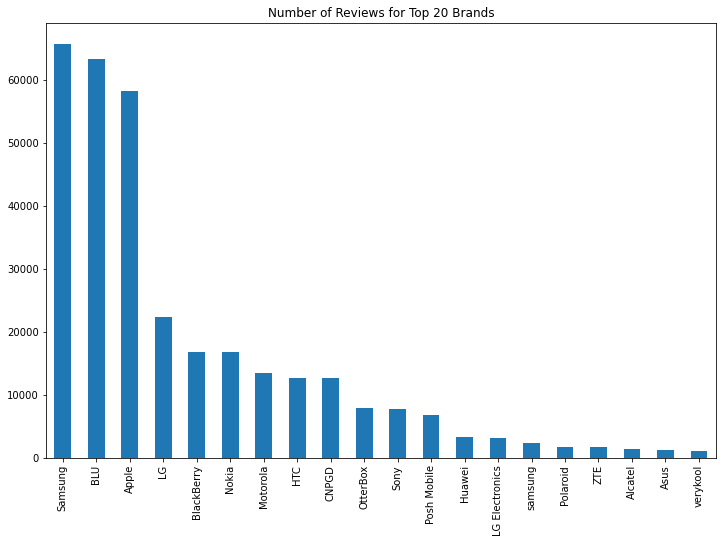

In [18]:

plt.figure(figsize=(12,8))
brands = df["Brand Name"].value_counts()
brands[:20].plot(kind='bar')

plt.title("Number of Reviews for Top 20 Brands")

In [25]:
df.dropna(inplace = True)
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334335 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  334335 non-null  object 
 1   Brand Name    334335 non-null  object 
 2   Price         334335 non-null  float64
 3   Rating        334335 non-null  int64  
 4   Reviews       334335 non-null  object 
 5   Review Votes  334335 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 17.9+ MB


In [26]:
df_final = df[df['Rating'] != 3]
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308277 entries, 0 to 413839
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Product Name  308277 non-null  object 
 1   Brand Name    308277 non-null  object 
 2   Price         308277 non-null  float64
 3   Rating        308277 non-null  int64  
 4   Reviews       308277 non-null  object 
 5   Review Votes  308277 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 16.5+ MB


In [28]:
df_final['sentiment'] = np.where(df_final['Rating'] >3 , 1, 0)
df_final.head()

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_12336/3038966242.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['sentiment'] = np.where(df_final['Rating'] >3 , 1, 0)


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,1
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,1
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,1


<AxesSubplot:>

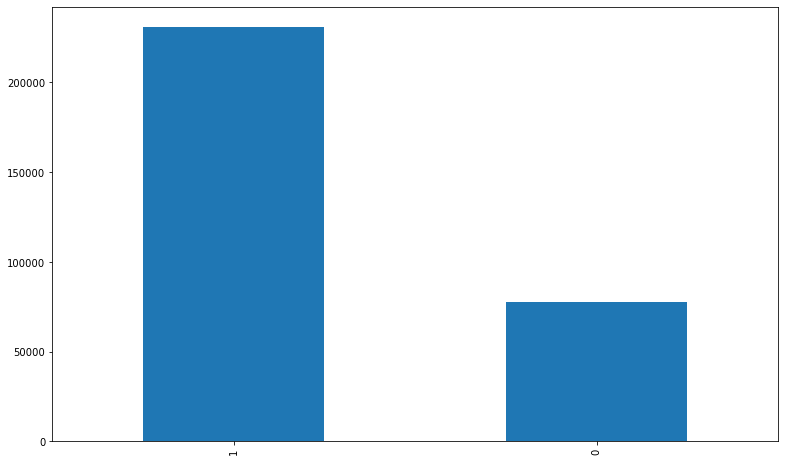

In [34]:
plt.figure(figsize  = (13,8))
df_final['sentiment'].value_counts().plot(kind= "bar")

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df_final['Reviews'], df_final['sentiment'], 
                                                    test_size=0.1, random_state=0)


In [39]:
print("Load traing examples are {0} and test examples are {1}".format(X_train.shape[0] , X_test.shape[0]))

Load traing examples are 277449 and test examples are 30828


In [41]:
def clean_text(raw_text , remove_stopwords= False , stemming = False , split_text = False):
    text = BeautifulSoup(raw_text , 'lxml').get_text()
    letter = re.sub("[^a-zA-Z]" , " " , text)
    words = letter.lower().split
    if remove_stopwords :
        stops = set(stopwords.words('english'))
        word = [ w for w in words if not w in stops]
    if stemming == True :
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in word]
    if split_text == True :
        return (words)
    return ("  ".join(words))


In [45]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True:
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True: 
        return (words)
    
    return( " ".join(words))
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://www.amazon.com/gp/product/B00U8KSNB0/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/B0193D539M?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an H

Show a cleaned review in the training set : 
 it is very good responsible seller


C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\bs4\__init__.py:431: MarkupResemblesLocatorWarning: "https://www.amazon.com/dp/B00QF5QJR2/ref=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [49]:
Count_vector = CountVectorizer()
X_train_countvec = Count_vector.fit_transform(X_train_cleaned)
X_test_countvec = Count_vector.transform(X_test_cleaned)
print("The number of features : " , len(Count_vector.get_feature_names()))
print("The feature name : " , Count_vector.get_feature_names()[::100])

The number of features :  50646
The feature name :  ['aa', 'abort', 'acaba', 'accidentally', 'acepar', 'acsd', 'actuator', 'addon', 'adn', 'advertiesd', 'afganistan', 'ages', 'ahrd', 'al', 'alla', 'alongside', 'alvjd', 'amazonused', 'amper', 'andgetting', 'angf', 'anoused', 'anymorepros', 'aperson', 'appereance', 'appscon', 'arch', 'arraive', 'asasas', 'asphalt', 'astute', 'attaches', 'audios', 'automate', 'avgthreatlabs', 'awful', 'baby', 'badcustomerexperience', 'ballsy', 'barquisimeto', 'bathrooms', 'bazels', 'beautifulit', 'beforehand', 'belongs', 'bestthank', 'bibbyelectronics', 'biscayne', 'blackplease', 'blesses', 'blotted', 'bmi', 'bone', 'borrar', 'boxes', 'breakfast', 'briskly', 'bsod', 'bugger', 'bumpers', 'buteven', 'buywell', 'caidas', 'calles', 'camerai', 'cancell', 'capacitythe', 'care', 'carrying', 'categor', 'cellar', 'centimeters', 'challenges', 'charging', 'cheating', 'childhood', 'choosed', 'churning', 'civilization', 'clearfast', 'closeout', 'cobalt', 'colleagues',

In [51]:
mnb = MultinomialNB()
mnb.fit(X_train_countvec, y_train)

MultinomialNB()

In [52]:
def modelEvaluation(predictions):
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))
    
predictions = mnb.predict(X_test_countvec)
modelEvaluation(predictions)


Accuracy on validation set: 0.9266

AUC score : 0.8945

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      7710
           1       0.94      0.96      0.95     23118

    accuracy                           0.93     30828
   macro avg       0.91      0.89      0.90     30828
weighted avg       0.93      0.93      0.93     30828


Confusion Matrix : 
 [[ 6403  1307]
 [  957 22161]]


In [53]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(tfidf.get_feature_names())) #1722
print("Show some feature names : \n", tfidf.get_feature_names()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Number of features : 18314 

Show some feature names : 
 ['aa', 'ascending', 'break', 'commms', 'debating', 'dumbfounded', 'fair', 'golpes', 'import', 'late', 'microp', 'ooh', 'popped', 'recieve', 'say', 'sone', 'tedious', 'unfortunatelly', 'withstand']


C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [54]:
feature_names = np.array(tfidf.get_feature_names())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['not' 'worst' 'useless' 'terrible' 'waste' 'disappointed' 'return' 'poor'
 'horrible' 'junk']

Top 10 features with largest coefficients : 
['love' 'great' 'excellent' 'amazing' 'perfect' 'awesome' 'easy'
 'perfectly' 'loves' 'best']


C:\Users\Lenovo\.conda\envs\laraib\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [55]:
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9511

AUC score : 0.9294

Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.89      0.90      7710
           1       0.96      0.97      0.97     23118

    accuracy                           0.95     30828
   macro avg       0.94      0.93      0.93     30828
weighted avg       0.95      0.95      0.95     30828


Confusion Matrix : 
 [[ 6830   880]
 [  626 22492]]
